In [5]:
import os
import jax
import pickle
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WoLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WoLF-MD": "gold",
    "KF-B": "darkorange",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def build_diff_df(data):
    statev = data["datasets"]["latent"]
    err_methods = jax.tree_map(lambda x: x - statev, data["posterior-states"])
    name = data["name"]

    diff_df = jax.tree_map(lambda x: np.sum(x ** 2, axis=1), err_methods)

    diff_df = pd.concat([
        pd.DataFrame(diff_df[k]).reset_index().melt("index").assign(method=k)
        for k in diff_df
    ])
    diff_df = diff_df.rename(
        {
            "variable": "state",
            "value": "error",
            "index": "trial"
        },
        axis=1
    )

    diff_df["kind"] = name
    return diff_df

In [8]:
kinds = ["mean", "covariance"]

data = {}
for kind in kinds:
    file = f"./results/2d-ssm-outlier-{kind}.pkl"
    with open(file, "rb") as f:
        data_single = pickle.load(f)
    data[kind] = data_single

## Plots

/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and wil

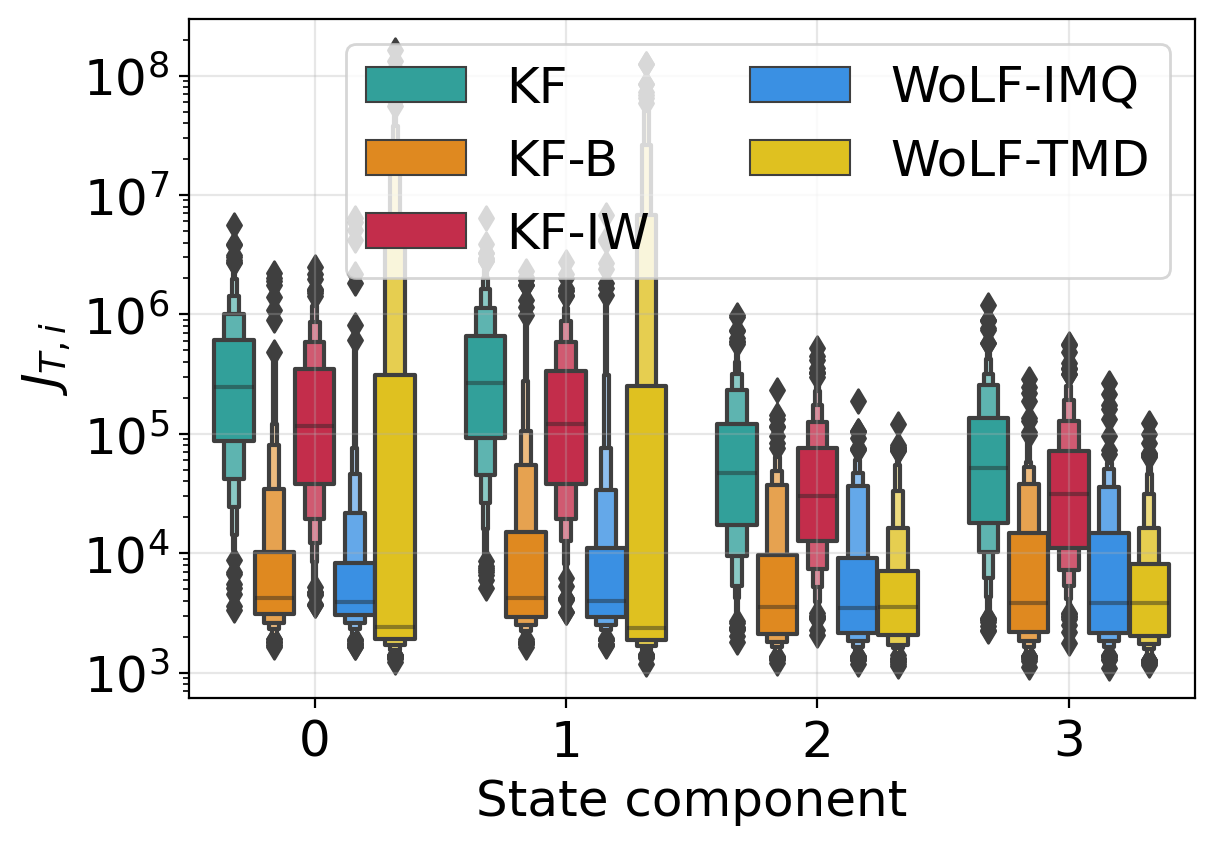

In [44]:
kind = "mean"
diff_df = build_diff_df(data[kind])

methods = sorted(diff_df.method.unique())
p = sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df,
    palette=cmap,
    hue_order=methods,
)

for text in p.legend(ncol=2).texts:
    text.set_text(text.get_text().replace("-MD", "-TMD"))


plt.xlabel("State component")
plt.ylabel("$J_{T,i}$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale("log")

# legend = plt.legend()
# labels = [v.get_text().replace("-MD", "-TMD") for v in legend.get_texts()]
# plt.legend(labels=labels)

plt.savefig(f"./figures/2d-ssm-comparison-outlier-{kind}.png", dpi=300)

In [45]:
# remove first iteration (used to compile functions)
time_df = pd.DataFrame(data[kind]["time"]).iloc[1:]

In [46]:
((time_df / time_df["KF"].median(axis=0)).describe().drop("KF", axis=1)).T["50%"].round(1)

KF-IW       5.7
WoLF-IMQ    1.0
WoLF-MD     1.1
KF-B        3.7
Name: 50%, dtype: float64

## Single model comparison

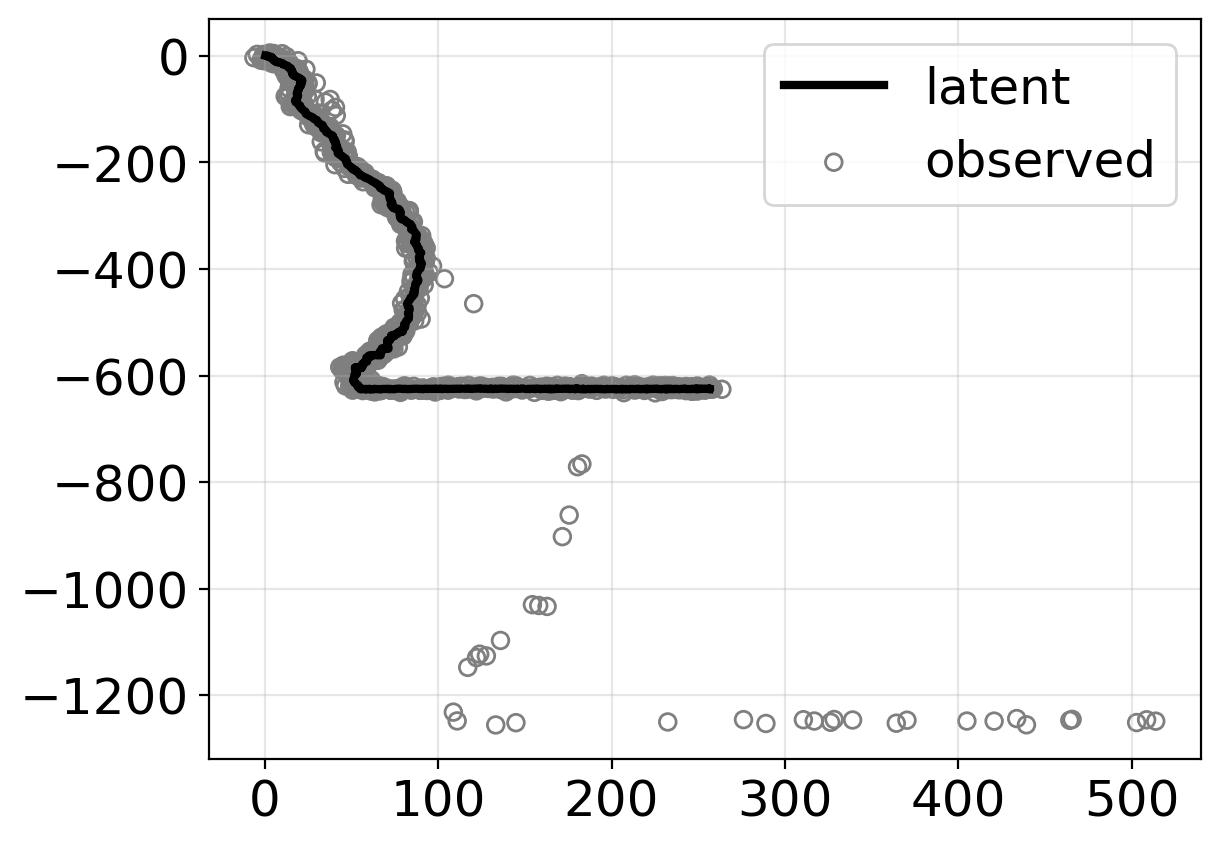

In [47]:
i = 11
# i = 2
i = 1
# kind = "covariance"
latent_i = data[kind]["datasets"]["latent"][i, :, :2].T
observed_i = data[kind]["datasets"]["observed"][i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)

In [48]:
titles = {
    "mean": "Mixture",
    "covariance": "Student"
}

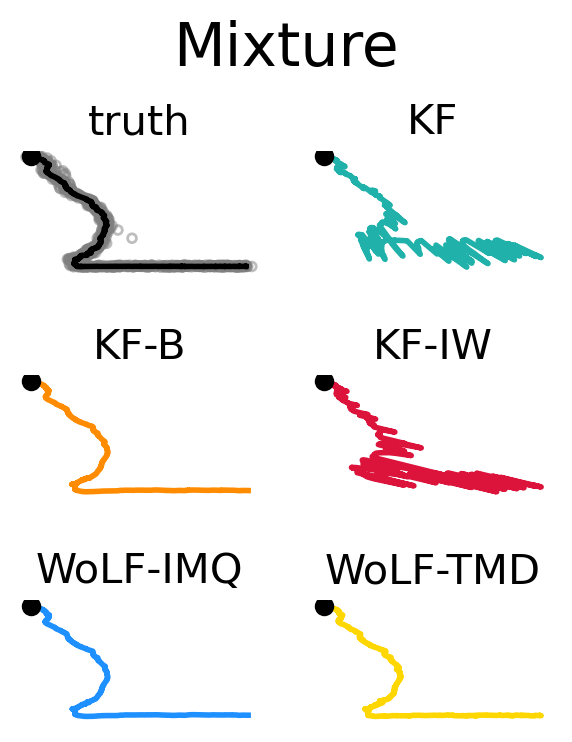

In [49]:
hist_runs = jax.tree_map(lambda x: x[i, :, :2], data[kind]["posterior-states"])

fig, axs = plt.subplots(3, 2, figsize=(6.4 * 0.5, 4.2))

fs = 15
for ax, key in zip(axs.ravel()[1:], hist_runs):
    state_est = hist_runs[key]
    ax.plot(*state_est.T, c=cmap[key], linewidth=2)
    
    key_new = key.replace("-MD", "-TMD")
    
    ax.set_title(key_new, fontsize=fs)
    ax.axis("off")
    ax.scatter(0,0, c="black", zorder=3)
    
ylim = ax.get_ylim()
xlim = ax.get_xlim()

axs[0, 0].scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed", alpha=0.5, s=10)
axs[0, 0].plot(*latent_i, c="black", label="latent", linewidth=2.0)
axs[0, 0].axis("off")
axs[0, 0].scatter(0, 0, c="black", zorder=3)
axs[0, 0].set_ylim(*ylim)
axs[0, 0].set_xlim(*xlim)
axs[0, 0].set_title("truth", fontsize=fs)
plt.suptitle(titles[kind], y=0.9)


plt.tight_layout()
plt.savefig(f"./figures/2d-ssm-comparison-single-run-{kind}.png", dpi=300, bbox_inches="tight")

## Single plot for both variants

In [34]:
diff_df = pd.concat([build_diff_df(data["mean"]), build_diff_df(data["covariance"])], axis=0)

diff_df["kind"] = diff_df["kind"].apply(lambda x: titles[x])
sortv = ["Student", "Mixture"]

/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and wil

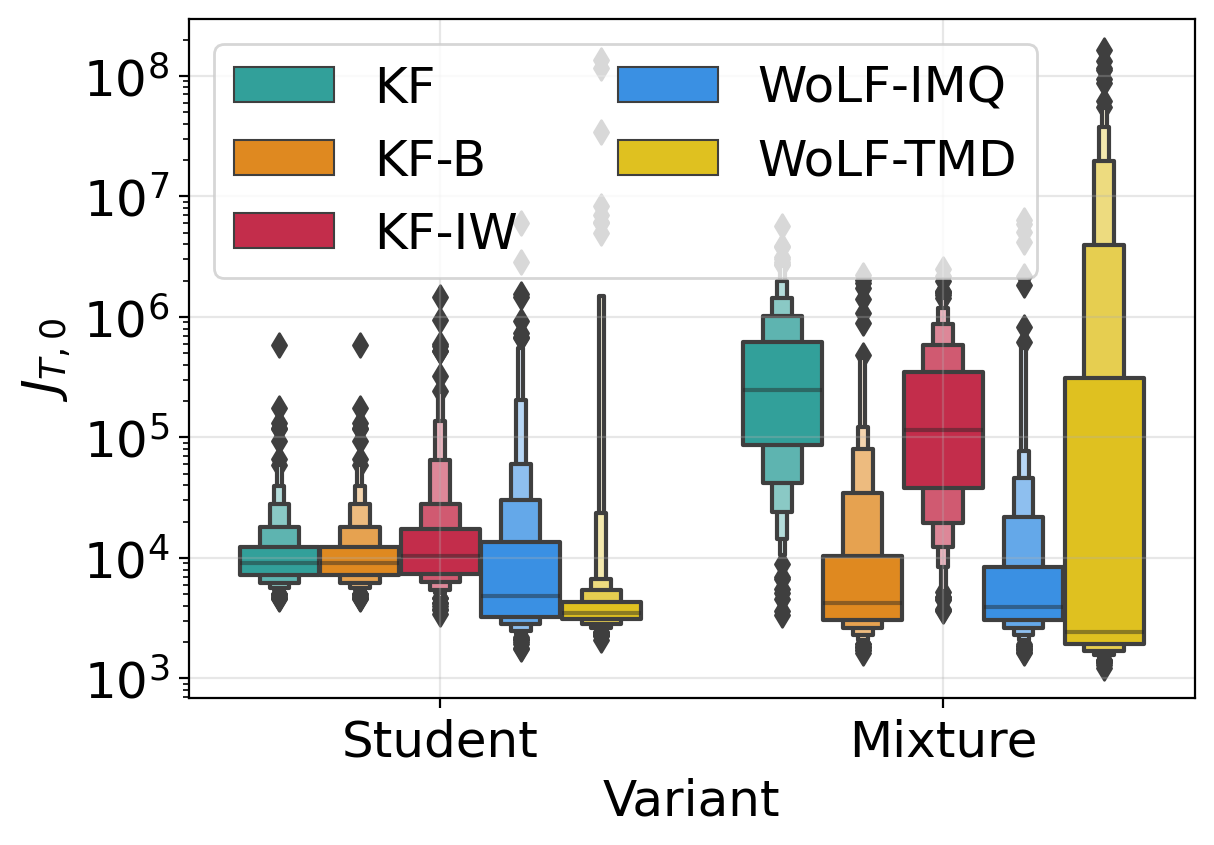

In [35]:
methods = sorted(diff_df.method.unique())
p = sns.boxenplot(
    y="error",
    x="kind",
    hue="method",
    data=diff_df.query("state == 0"),
    palette=cmap,
    hue_order=methods,
    order=sortv,
)

for text in p.legend(ncol=2).texts:
    text.set_text(text.get_text().replace("-MD", "-TMD"))

plt.xlabel("Variant")
plt.ylabel("$J_{T,0}$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale("log")
plt.savefig(f"./figures/2d-ssm-comparison-outlier-both.png", dpi=300)